# Project: Exploratory Data Analysis on Seattle Airbnb Data
### Project Due on 3rd April, 11:30 pm EST

#### Context
Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.

#### Content
The following Airbnb data is included in this Seattle dataset:
- Listings, including full descriptions and average review score
- Reviews, including unique id for each reviewer and detailed comments
- Calendar, including listing id and the price and availability for that day

**To get the dataset click [here](https://georgiancollege-my.sharepoint.com/:f:/g/personal/katie_tiwari_georgiancollege_ca/Eh6hG8jQX_FBvU_pk5R5wZwB_xn5gS2eBE1vWQ_DmaH1kQ?e=evqomn)**

#### Inspiration for questions
- Can you describe the vibe of each Seattle neighborhood using listing descriptions?
- What are the busiest times of the year to visit Seattle? By how much do prices spike?
- Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

#### **Note:** Don't discuss the results, limitations, conclusion, reasons as comment in the code cell. Use separate markdown cells instead. If you are not familier with markdown, refer this [link here](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook). Only add code related comments as comment in the code cell. Also Make sure to add comments in the code.

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

In [1]:
# coding=utf-8
import os
import math
import time
import joblib
import random
import numpy as np
import pandas as pd
import random as rd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import category_encoders as ce
from time import time
from xgboost import *
from scipy.stats import normaltest, linregress
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.ensemble import *
from sklearn.datasets import load_digits, make_hastie_10_2, load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# %matplotlib
# %matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 5000)

<a id='intro'></a>
## Introduction

> In this section of the report, provide a brief introduction to the dataset you've selected for analysis. 

- Create atleast three complex and meaningful questions(refer inspiration questions to get an idea), then address those questions in the rest of the analysis. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.
- **Include the 3 research questions here**



In [2]:
# Use this, and more code cells, to explore your data. Don't forget to add markdown cells to document your observations and findings.


***

1. Which neightbourhood earns more money?
2. What kind of listings have a higher price?
3. What's the trends of occupation rate in difference neighbourhoods?

***

<a id='wrangling'></a>
## Data Wrangling

> In this section of the report, you will load in the data, check for cleanliness, merging multiple files, printing some rows of the data in output, handling missing values, duplicat values, outliers etc. and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and privde the reasoning for every decision taken.

#### Use this, and more code cells, to explore your data. Don't forget to add markdown cells to document your observations and findings. 

In [3]:
class Foo:
    def __init__(self, file_name):
        self.df = pd.read_csv('./' + file_name)
        pass

    def null_value_visualization(self):
        print(self.df.isnull().any())
        plt.figure(figsize=(self.df.shape[1] / 2, 3), dpi=100)
        sns.heatmap(self.df.isnull(), cmap="viridis")
        pass

    def categorical_data_dist(self, c):
        f = self.df.groupby(c).count()
        f = f.sort_values(by=f.columns[0], ascending=False)
        f = f[f.columns[0]]
        return f

    def plot_categorical_data_distribution(self):
        fig = plt.figure(figsize=(8, 23), dpi=150, constrained_layout=True)
        gs = GridSpec(23, 4, figure=fig, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

        for i, c in enumerate(self.df.columns):
            f = self.categorical_data_dist(c)
            x = i // 4
            y = i % 4
            ax = fig.add_subplot(gs[x, y])
            ax.plot(f.values[:50])
            ax.set_xticklabels([])

            ttl = "col = %s\nunique=%d" % (c, len(f.values))
            is_null = self.df[c].isnull().any()
            if not is_null:
                ttl += "\n isnull : %s" % str(is_null)
            else:
                nul = self.df[c].isnull().sum()
                tot = self.df[c].isnull().count()
                ttl += "\n null : %.2f%%" % (nul / tot * 100)
            ax.set_title(ttl, fontsize=6)
        plt.show()
        pass

## 1.1. calendar.csv

listing_id    False
date          False
available     False
price          True
dtype: bool


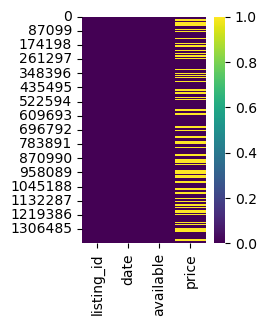

In [4]:
# loading data and have a glance
calendar = Foo('calendar.csv')
calendar.null_value_visualization()

In [5]:
# money to float, fillna()
calendar.df['price'] = calendar.df['price'].fillna(float(0.0)).replace("[$,]", "", regex=True).astype(float)

In [6]:
calendar.df['month'] = pd.DatetimeIndex(calendar.df['date']).month
calendar.df

,listing_id,date,available,price,month
0,241032,2016-01-04,t,85.0,1
1,241032,2016-01-05,t,85.0,1
2,241032,2016-01-06,f,0.0,1
3,241032,2016-01-07,f,0.0,1
4,241032,2016-01-08,f,0.0,1
...,...,...,...,...,...
1393565,10208623,2016-12-29,f,0.0,12
1393566,10208623,2016-12-30,f,0.0,12
1393567,10208623,2016-12-31,f,0.0,12
1393568,10208623,2017-01-01,f,0.0,1


listing_id    False
date          False
available     False
price         False
month         False
dtype: bool


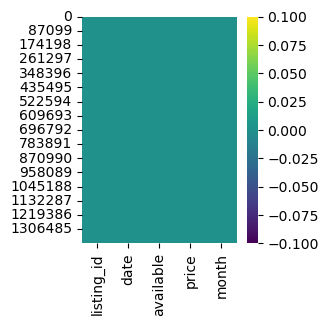

In [7]:
calendar.null_value_visualization()

## 1.2. reviews.csv

listing_id       False
id               False
date             False
reviewer_id      False
reviewer_name    False
comments          True
dtype: bool


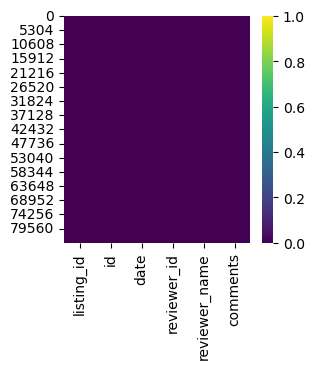

In [8]:
# loading data and have a glance
reviews = Foo('reviews.csv')
reviews.null_value_visualization()

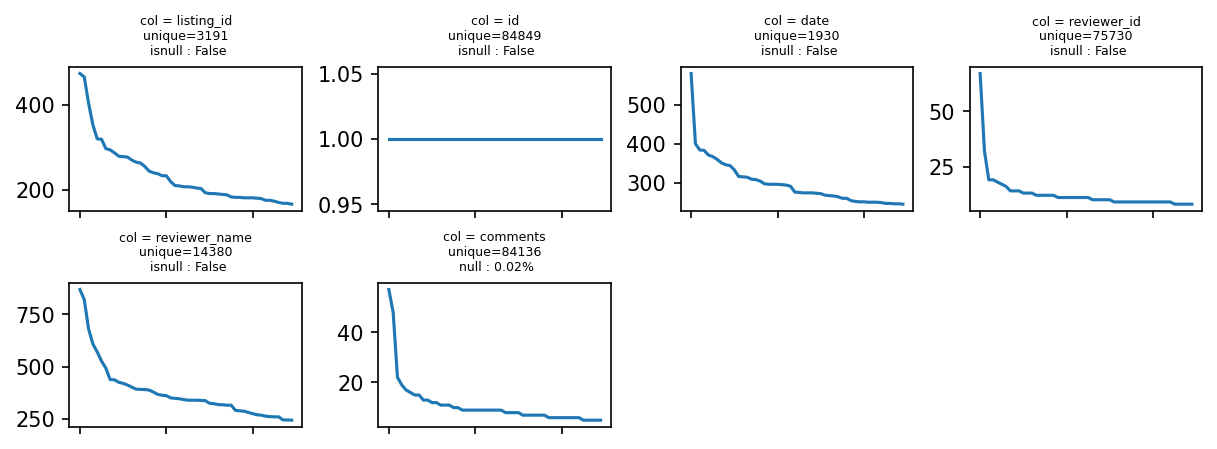

In [9]:
reviews.plot_categorical_data_distribution()

listing_id       False
id               False
date             False
reviewer_id      False
reviewer_name    False
comments         False
dtype: bool


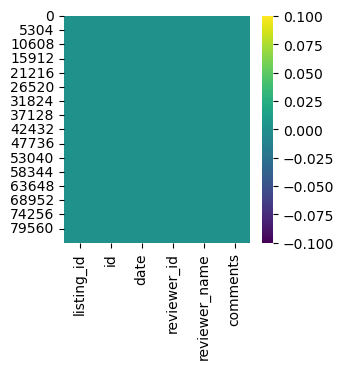

In [10]:
reviews.df['comments'] = reviews.df['comments'].fillna('')
reviews.null_value_visualization()

# 1.2.1. the date range is different between reviews and calendar

***

The dates of calendar table are from **2016-01-04** to **2017-01-02**.

The dates of reviews are from **2009-06-07** to **2016-01-03**, which is just **one day before** calendar table.

So I decide not to merge this two tables with listing_id.

If it's needed to merge these two tables later on, it's better to concat these two tables in time sequence order, not extend columns and merge them with listing_id.

***

In [11]:
reviews.df[['date']].sort_values(by='date', ascending=True)

,date
34876,2009-06-07
34877,2009-06-28
12622,2009-07-17
15249,2009-08-31
15250,2009-09-10
...,...
53165,2016-01-03
43186,2016-01-03
49870,2016-01-03
25909,2016-01-03


In [12]:
calendar.df[['date']].sort_values(by='date', ascending=True)

,date
0,2016-01-04
1171285,2016-01-04
442380,2016-01-04
997180,2016-01-04
1203040,2016-01-04
...,...
924544,2017-01-02
924179,2017-01-02
923814,2017-01-02
928194,2017-01-02


## 1.3. listings.csv

id                                  False
listing_url                         False
scrape_id                           False
last_scraped                        False
name                                False
summary                              True
space                                True
description                         False
experiences_offered                 False
neighborhood_overview                True
notes                                True
transit                              True
thumbnail_url                        True
medium_url                           True
picture_url                         False
xl_picture_url                       True
host_id                             False
host_url                            False
host_name                            True
host_since                           True
host_location                        True
host_about                           True
host_response_time                   True
host_response_rate                

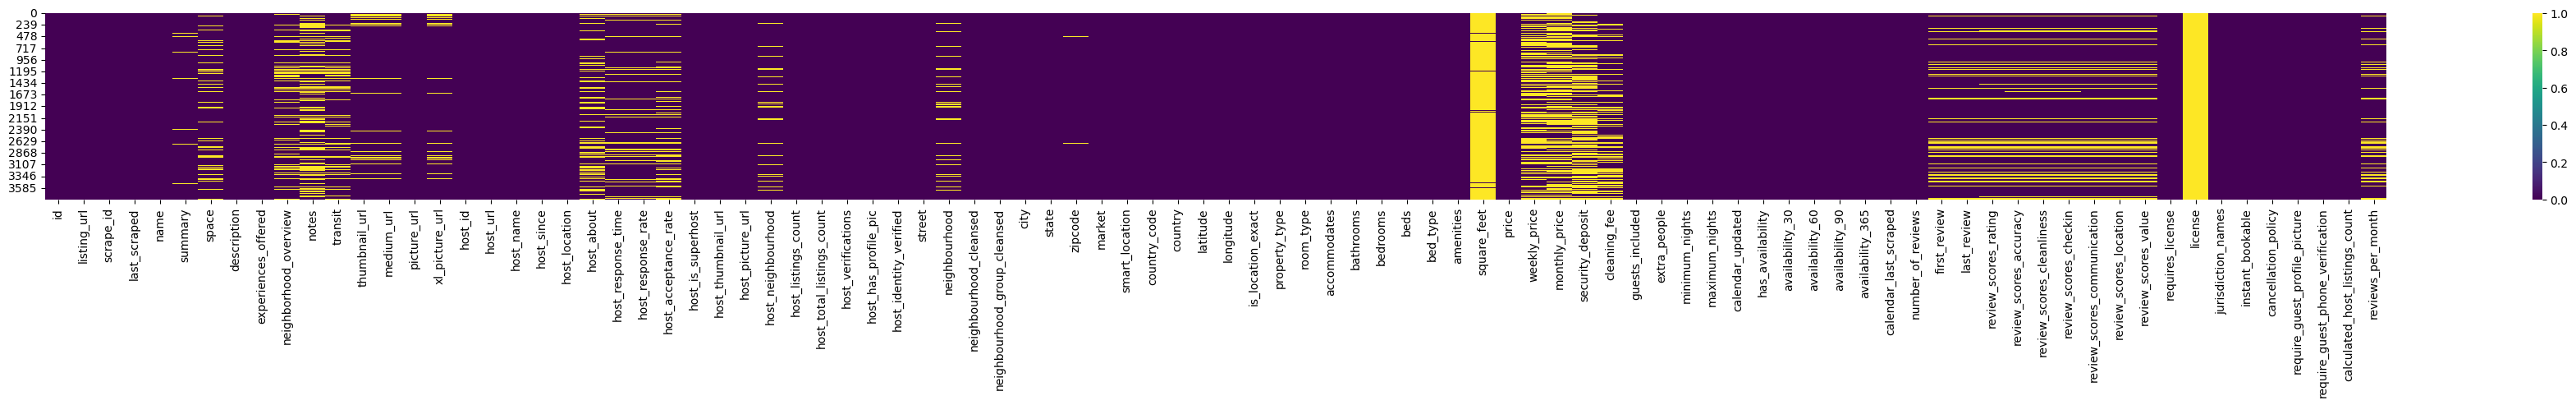

In [13]:
# loading data and have a glance
listings = Foo('listings.csv')
listings.null_value_visualization()

## 1.3.1. drop columns

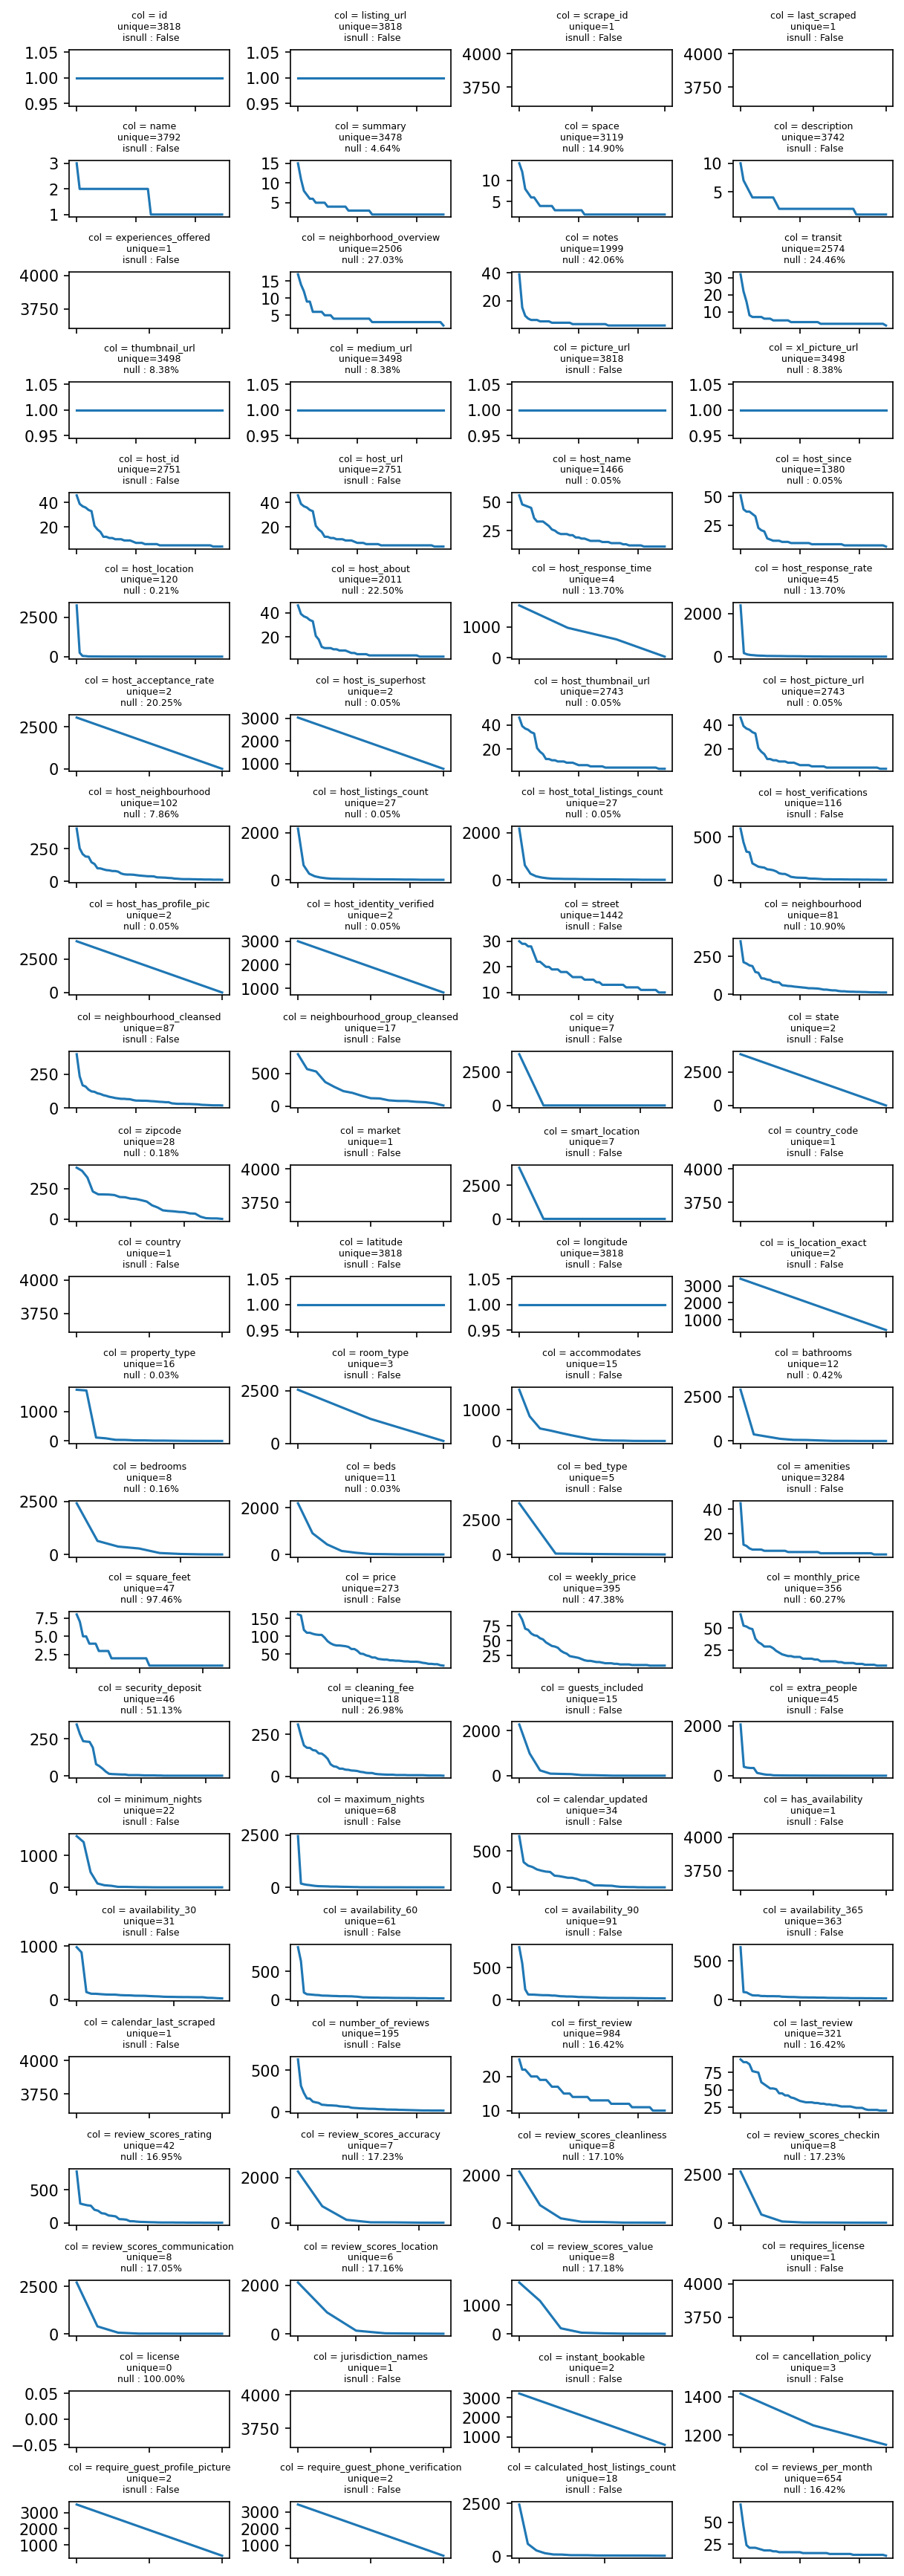

In [14]:
listings.plot_categorical_data_distribution()

#### drop columns

In [15]:
listings = Foo('listings.csv')
drop_off_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'thumbnail_url', 'medium_url', 
                'picture_url', 'xl_picture_url', 'market', 'country_code', 'country', 'has_availability',
                'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 'square_feet', 
                'host_url', 'host_response_time', 'host_response_rate', 'host_thumbnail_url', 'host_picture_url', 
                'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 
                 'street', 'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 
                 'country', 'is_location_exact', 'square_feet', 'weekly_price', 'monthly_price', 'calendar_updated', 
                 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
                 'calendar_last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 
                 'notes', 'transit', 'host_id', 
                ]
listings.df = listings.df.drop(drop_off_cols, axis=1)
listings.df.shape

(3818, 44)

## 1.3.2. fillna()

In [16]:
# loading data and have a glance
listings = Foo('listings.csv')
drop_off_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'thumbnail_url', 'medium_url', 
                'picture_url', 'xl_picture_url', 'market', 'country_code', 'country', 'has_availability',
                'calendar_last_scraped', 'requires_license', 'license', 'jurisdiction_names', 'square_feet', 
                'host_url', 'host_response_time', 'host_response_rate', 'host_thumbnail_url', 'host_picture_url', 
                'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 
                 'street', 'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 
                 'country', 'is_location_exact', 'square_feet', 'weekly_price', 'monthly_price', 'calendar_updated', 
                 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
                 'calendar_last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 
                 'notes', 'transit', 'host_id', 
                ]
listings.df = listings.df.drop(drop_off_cols, axis=1)

listings.df['price'] = listings.df['price'].replace("[$,]", "", regex=True).fillna(0).astype(float)
listings.df['extra_people'] = listings.df['extra_people'].replace("[$,]", "", regex=True).fillna(0).astype(float)
# listings.df['weekly_price'] = listings.df['weekly_price'].replace("[$,]", "", regex=True).fillna(0).astype(float)
# listings.df['monthly_price'] = listings.df['monthly_price'].replace("[$,]", "", regex=True).fillna(0).astype(float)

# listings.df['summary'] = listings.df['summary'].fillna('')
# listings.df['space'] = listings.df['space'].fillna('')

# listings.df['neighborhood_overview'] = listings.df['neighborhood_overview'].fillna('')
# listings.df['notes'] = listings.df['notes'].fillna('')
# listings.df['transit'] = listings.df['transit'].fillna('')

listings.df['host_about'] = listings.df['host_about'].fillna('')
# listings.df['host_response_time'] = listings.df['host_response_time'].fillna('')

# listings.df['host_response_rate'] = listings.df['host_response_rate'].str.rstrip('%').fillna(0).astype(float) / 100.0
listings.df['host_acceptance_rate'] = listings.df['host_acceptance_rate'].str.rstrip('%').fillna(0).astype(float) / 100.0
# listings.df['host_neighbourhood'] = listings.df['host_neighbourhood'].fillna('')
# listings.df['neighbourhood'] = listings.df['neighbourhood'].fillna('')
# listings.df['zipcode'] = listings.df['zipcode'].fillna('')
listings.df['security_deposit'] = listings.df['security_deposit'].replace("[$,]", "", regex=True).fillna(0).astype(float)
listings.df['cleaning_fee'] = listings.df['cleaning_fee'].replace("[$,]", "", regex=True).fillna(0).astype(float)

listings.df['first_review'] = listings.df['first_review'].fillna('1970-01-01')
listings.df['last_review'] = listings.df['last_review'].fillna('1970-01-01')
listings.df['review_scores_rating'] = listings.df['review_scores_rating'].fillna(0) / 100
listings.df['review_scores_accuracy'] = listings.df['review_scores_accuracy'].fillna(float(listings.df['review_scores_accuracy'].mode()))
listings.df['review_scores_cleanliness'] = listings.df['review_scores_cleanliness'].fillna(float(listings.df['review_scores_cleanliness'].mode()))
listings.df['review_scores_checkin'] = listings.df['review_scores_checkin'].fillna(float(listings.df['review_scores_checkin'].mode()))
listings.df['review_scores_communication'] = listings.df['review_scores_communication'].fillna(float(listings.df['review_scores_communication'].mode()))
listings.df['review_scores_location'] = listings.df['review_scores_location'].fillna(float(listings.df['review_scores_location'].mode()))
listings.df['review_scores_value'] = listings.df['review_scores_value'].fillna(float(listings.df['review_scores_value'].mean()))
listings.df['reviews_per_month'] = listings.df['reviews_per_month'].fillna(float(listings.df['reviews_per_month'].mean()))

listings.df['host_name'] = listings.df['host_name'].fillna('')
listings.df['host_since'] = listings.df['host_since'].fillna('1970-01-01')
listings.df['host_location'] = listings.df['host_location'].fillna('')

# listings.df['host_thumbnail_url'] = listings.df['host_thumbnail_url'].fillna('')
# listings.df['host_picture_url'] = listings.df['host_picture_url'].fillna('')
# listings.df['host_listings_count'] = listings.df['host_listings_count'].fillna(float(listings.df['host_listings_count'].mode()))
# listings.df['host_total_listings_count'] = listings.df['host_total_listings_count'].fillna(float(listings.df['host_total_listings_count'].mode()))
listings.df['property_type'] = listings.df['property_type'].fillna('')

listings.df['bathrooms'] = listings.df['bathrooms'].fillna(float(listings.df['bathrooms'].mode()))
listings.df['bedrooms'] = listings.df['bedrooms'].fillna(float(listings.df['bedrooms'].mode()))
listings.df['beds'] = listings.df['beds'].fillna(float(listings.df['beds'].mode()))

listings.df['host_is_superhost'] = listings.df['host_is_superhost'].fillna(str(listings.df['host_is_superhost'].mode()))
listings.df['host_has_profile_pic'] = listings.df['host_has_profile_pic'].fillna(str(listings.df['host_has_profile_pic'].mode()))
listings.df['host_identity_verified'] = listings.df['host_identity_verified'].fillna(str(listings.df['host_identity_verified'].mode()))

for col, is_null in listings.df.isnull().any().to_dict().items():
    if is_null:
        print(listings.categorical_data_dist(col))

listings.df.shape

(3818, 44)

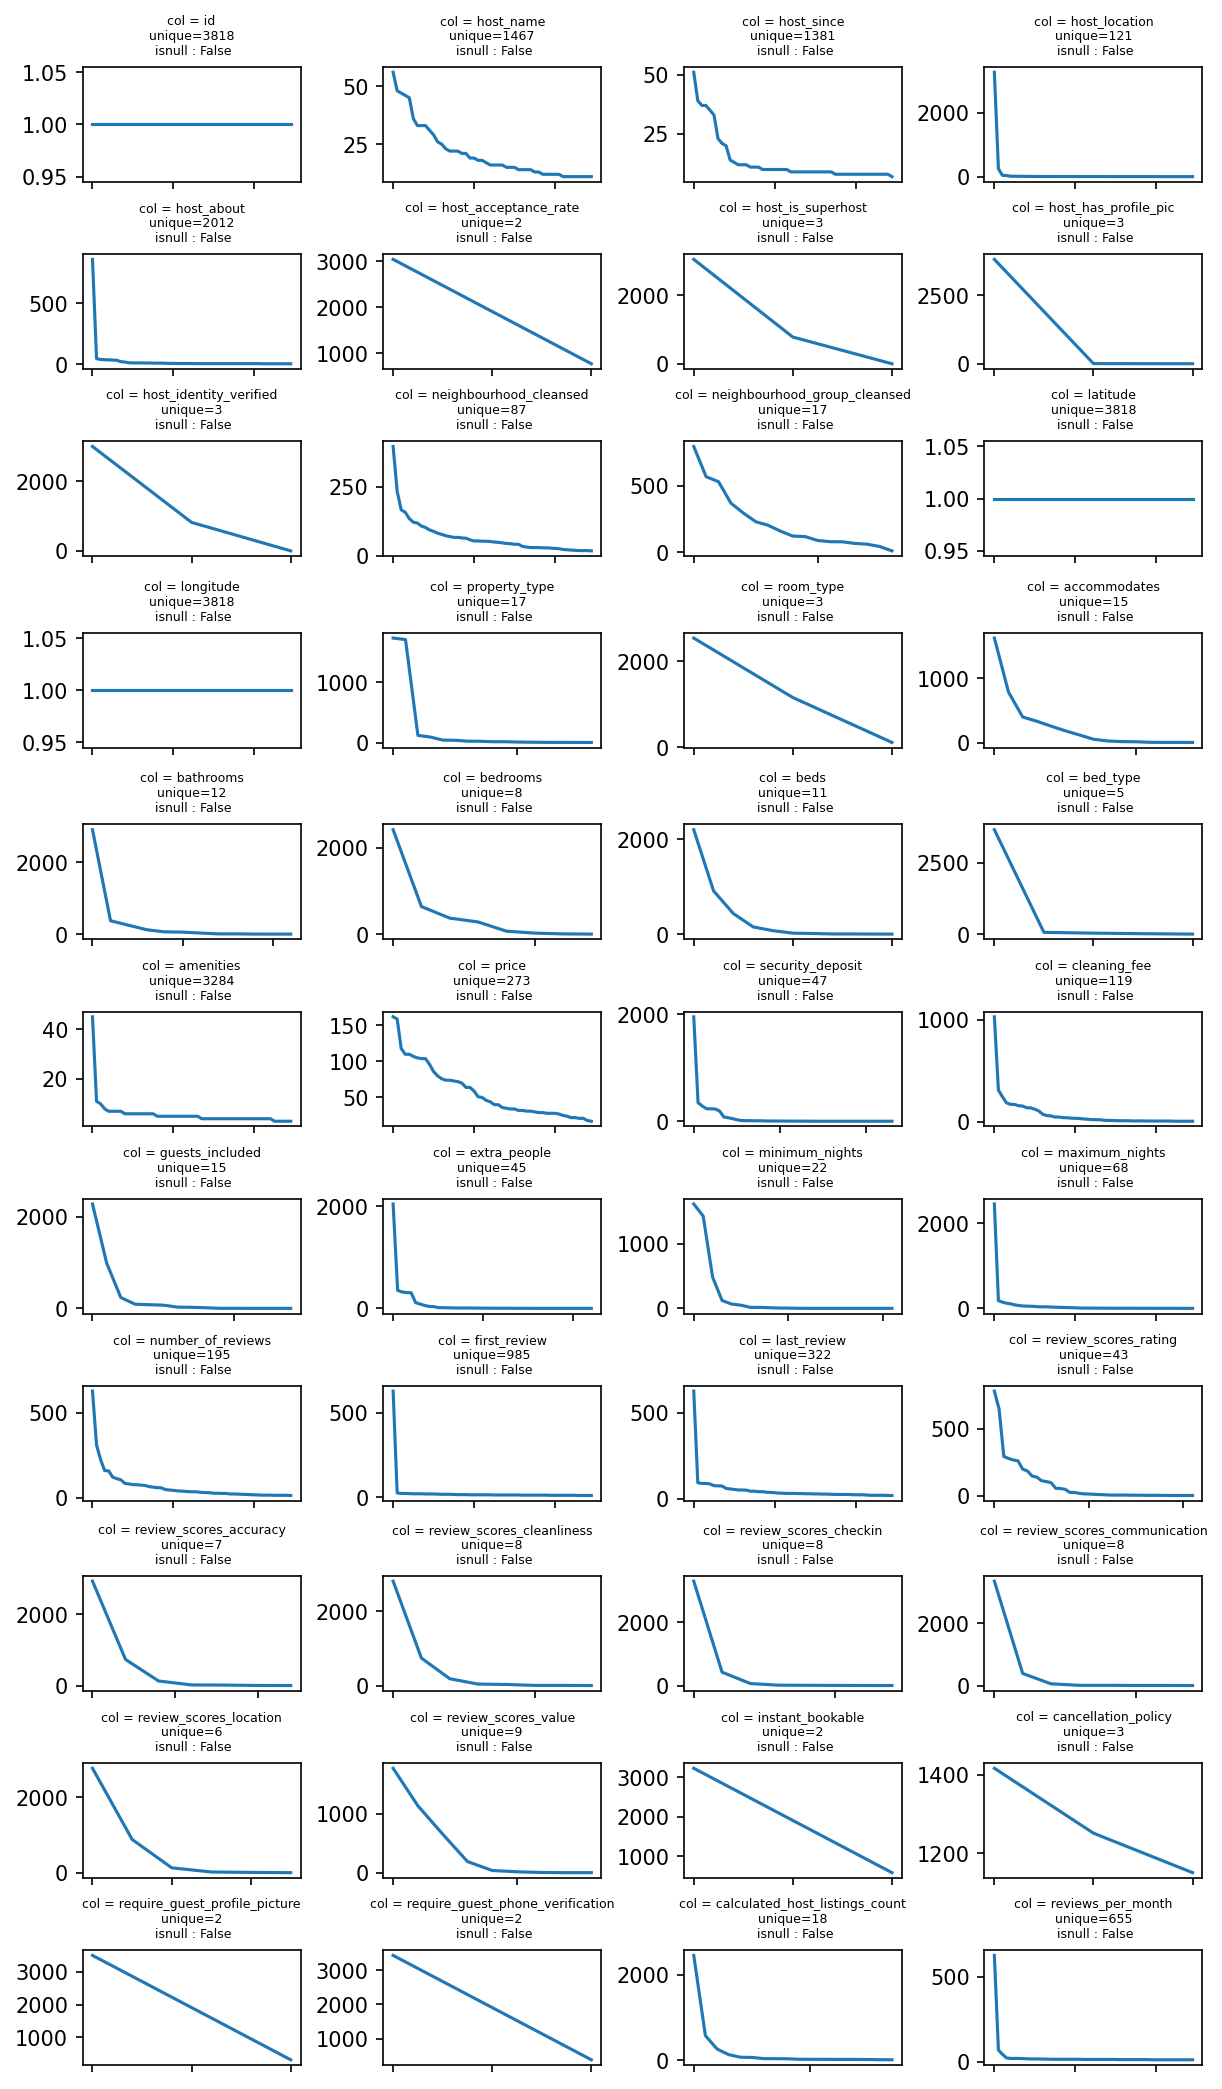

In [17]:
listings.plot_categorical_data_distribution()

id                                  False
host_name                           False
host_since                          False
host_location                       False
host_about                          False
host_acceptance_rate                False
host_is_superhost                   False
host_has_profile_pic                False
host_identity_verified              False
neighbourhood_cleansed              False
neighbourhood_group_cleansed        False
latitude                            False
longitude                           False
property_type                       False
room_type                           False
accommodates                        False
bathrooms                           False
bedrooms                            False
beds                                False
bed_type                            False
amenities                           False
price                               False
security_deposit                    False
cleaning_fee                      

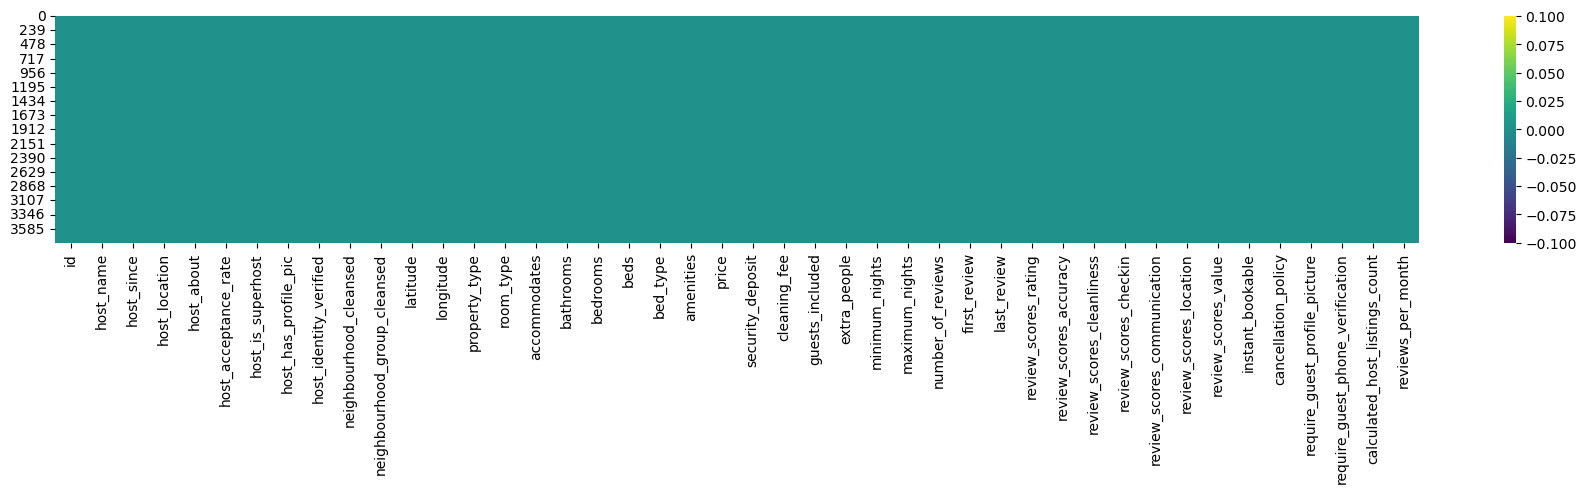

In [18]:
listings.null_value_visualization()

<a id='eda'></a>
## Exploratory Data Analysis

> Now you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. Look at one variable at a time, and then follow it up by looking at relationships between variables.

- The EDA should include both single-variable (1d) and multiple-variable (2d) explorations. 
- The project's visualizations should be varied and show multiple comparisons and trends. At least three kinds of plots(eg. histogram, box plot, line plot, bar plot, etc) should be created as part of the explorations.
- Please make sure reasoning is provided for each analysis decision, plot, and statistical summary.
- Visualizations made in the notebook, should depict the data in an appropriate manner (i.e., has appropriate axis labels, scale, legends, and title) that allows plots to be readily interpreted.

### Research Question 1 (Which neightbourhood earns more money?)

In [19]:
# Use this, and more code cells, to explore your data. Don't forget to add markdown cells to document your observations and findings.


In [20]:
# There are 3818 listings in this dataset. 
# Each listing concains 365 daily prices from '2016-01-04' to '2017-01-02'
occupancy_rate = calendar.df.groupby(['listing_id', 'available']).count()[['price']].unstack().reset_index().fillna(0)
cols = []
for mc in occupancy_rate.columns:
    if mc[0] == 'price':
        if mc[1] == 'f':
            col = "occupied"
        else:
            col = "opened"
    else:
        col = mc[0]
    cols.append(col)
occupancy_rate.columns = cols
# occupancy_rate['occupancy_rate'] = occupancy_rate['price_f'] / (occupancy_rate['price_f'] + occupancy_rate['price_t'])
occupancy_rate.head()


,listing_id,occupied,opened
0,3335,56.0,309.0
1,4291,0.0,365.0
2,5682,56.0,309.0
3,6606,0.0,365.0
4,7369,312.0,53.0


In [21]:
listing_income = calendar.df.groupby(['listing_id', 'available']).sum()[['price']].unstack().reset_index().fillna(0)
cols = []
for mc in listing_income.columns:
    if mc[1] != '':
        col = mc[0] + "_" + mc[1]
    else:
        col = mc[0]
    cols.append(col)
cols[2] = 'income'
listing_income.columns = cols
listing_income = listing_income[['listing_id', 'income']]
listing_income.head()

,listing_id,income
0,3335,37080.0
1,4291,29930.0
2,5682,16669.0
3,6606,33890.0
4,7369,4505.0


In [22]:
listings.df.head(2)

,id,host_name,host_since,host_location,host_about,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",1.0,f,t,t,West Queen Anne,Queen Anne,47.636289,-122.371025,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,207,2011-11-01,2016-01-02,0.95,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,1.0,t,t,t,West Queen Anne,Queen Anne,47.639123,-122.365666,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,43,2013-08-19,2015-12-29,0.96,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48


***

There are 2 neightbourhoods earns the most money than the others neightbourhoods, they are:

* **Broadway** \$12M
* **Belltown** \$10M

And the neightbourhoods with the top average incomes per listing are not the same as the total incomes in above list: 

* **Southeast Magnolia**: \$72k
* **Briarcliff**: \$68k
* **Alki**: \$64k

Here are the tables:

***

In [23]:
df0 = pd.merge(listing_income, listings.df[['id', 'neighbourhood_cleansed', 'latitude', 'longitude', 'number_of_reviews']], 
               left_on='listing_id', right_on='id')
df0 = pd.merge(df0, occupancy_rate[['listing_id', 'occupied', 'opened']], left_on='listing_id', right_on='listing_id')
df0 = df0.drop(['id'], axis=1)

df = df0[['neighbourhood_cleansed', 'income']].groupby(['neighbourhood_cleansed']).sum('income').sort_values(by='income', ascending=False)[['income']]
df['listing_cnt'] = df0[['neighbourhood_cleansed', 'listing_id']].groupby(['neighbourhood_cleansed']).count()
df['listing_income'] = df['income'] / df['listing_cnt']
df['occupied'] = df0[['neighbourhood_cleansed', 'occupied']].groupby(['neighbourhood_cleansed']).sum()
df['opened'] = df0[['neighbourhood_cleansed', 'opened']].groupby(['neighbourhood_cleansed']).sum()
df['reviews'] = df0[['neighbourhood_cleansed', 'number_of_reviews']].groupby(['neighbourhood_cleansed']).sum()
df['latitude'] = df0[['neighbourhood_cleansed', 'latitude']].groupby(['neighbourhood_cleansed']).mean()
df['longitude'] = df0[['neighbourhood_cleansed', 'longitude']].groupby(['neighbourhood_cleansed']).mean()
df['occupancy_rate'] = df['occupied'] / (df['occupied'] + df['opened'])

df = df.sort_values(by='listing_income', ascending=False)

df.head(10)

,income,listing_cnt,listing_income,occupied,opened,reviews,latitude,longitude,occupancy_rate
neighbourhood_cleansed,,,,,,,,,
Southeast Magnolia,1226363.0,17,72139.000000,1139.0,5066.0,281,47.643545,-122.388246,0.183562
Briarcliff,955509.0,14,68250.642857,688.0,4422.0,179,47.646219,-122.407149,0.134638
Portage Bay,896651.0,14,64046.500000,1310.0,3800.0,201,47.647939,-122.320468,0.256360
Windermere,584010.0,10,58401.000000,1003.0,2647.0,89,47.670212,-122.272097,0.274795
Central Business District,5638871.0,103,54746.320388,10194.0,27401.0,2526,47.609367,-122.335523,0.271153
Sunset Hill,972037.0,18,54002.055556,1059.0,5511.0,594,47.676701,-122.400488,0.161187
Holly Park,315237.0,6,52539.500000,62.0,2128.0,59,47.538609,-122.288208,0.028311
Pioneer Square,1199374.0,23,52146.695652,1781.0,6614.0,796,47.600935,-122.333340,0.212150
Industrial District,311528.0,6,51921.333333,315.0,1875.0,146,47.579755,-122.333199,0.143836


In [24]:
df = df.sort_values(by='income', ascending=False)

df.head(10)

,income,listing_cnt,listing_income,occupied,opened,reviews,latitude,longitude,occupancy_rate
neighbourhood_cleansed,,,,,,,,,
Broadway,12049369.0,397,30351.055416,54421.0,90484.0,8919,47.621266,-122.321223,0.375563
Belltown,10742532.0,234,45908.256410,32090.0,53320.0,4686,47.615147,-122.345487,0.375717
Fremont,5659684.0,158,35820.784810,18351.0,39319.0,4157,47.656413,-122.351154,0.318207
Central Business District,5638871.0,103,54746.320388,10194.0,27401.0,2526,47.609367,-122.335523,0.271153
Wallingford,5468311.0,167,32744.377246,18155.0,42800.0,4039,47.659765,-122.333458,0.297843
Minor,4237156.0,135,31386.340741,14850.0,34425.0,3455,47.609246,-122.309500,0.301370
Stevens,3821970.0,119,32117.394958,13239.0,30196.0,2436,47.624084,-122.306415,0.304800
First Hill,3582702.0,108,33173.166667,16120.0,23300.0,2517,47.610902,-122.326716,0.408929
University District,3470925.0,122,28450.204918,11382.0,33148.0,1316,47.662874,-122.314214,0.255603


***

This plot shows that the north part of these districts are have higher ability to earn money.

***

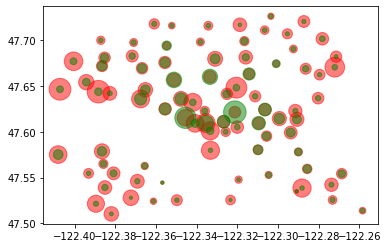

In [25]:
s1 = MinMaxScaler().fit_transform(df[['listing_income']]).flatten()
plt.scatter(df['longitude'].values, df['latitude'].values, s=(s1+0.02)*500, c='r', alpha=0.5)
s2 = MinMaxScaler().fit_transform(df[['income']]).flatten()
plt.scatter(df['longitude'].values, df['latitude'].values, s=(s2+0.02)*500, c='g', alpha=0.5)
plt.show()

***

The ability of earning money in particular district depends on the scale of listings in that area.

***

Text(0.5, 1.0, 'box plot of income per listing')

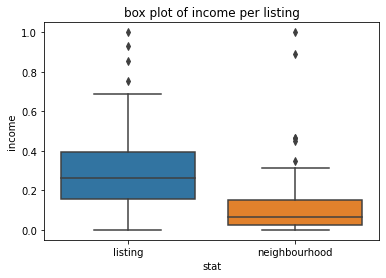

In [26]:
# plot box plot
tmp_df1 = pd.DataFrame(s1, columns=['income'])
tmp_df1['stat'] = 'listing'
tmp_df2 = pd.DataFrame(s2, columns=['income'])
tmp_df2['stat'] = 'neighbourhood'
tmp_df = pd.concat([tmp_df1, tmp_df2], axis=0).reset_index(drop=True)

sns.boxplot(y=tmp_df['income'], x=tmp_df['stat'])
plt.title('box plot of income per listing')

In [27]:
occupancy_rate = calendar.df.groupby(['listing_id', 'available']).count()[['price']].unstack().reset_index().fillna(0)
cols = []
for mc in occupancy_rate.columns:
    if mc[1] != '':
        col = mc[0] + "_" + mc[1]
    else:
        col = mc[0]
    cols.append(col)
occupancy_rate.columns = cols
# occupancy_rate['occupancy_rate'] = occupancy_rate['price_f'] / (occupancy_rate['price_f'] + occupancy_rate['price_t'])
occupancy_rate


,listing_id,price_f,price_t
0,3335,56.0,309.0
1,4291,0.0,365.0
2,5682,56.0,309.0
3,6606,0.0,365.0
4,7369,312.0,53.0
...,...,...,...
3813,10332096,0.0,365.0
3814,10334184,4.0,361.0
3815,10339144,365.0,0.0
3816,10339145,0.0,365.0


In [28]:
df1 = pd.merge(df0, occupancy_rate, left_on='listing_id', right_on='listing_id')
df1

,listing_id,income,neighbourhood_cleansed,latitude,longitude,number_of_reviews,occupied,opened,price_f,price_t
0,3335,37080.0,Dunlap,47.529846,-122.275840,0,56.0,309.0,56.0,309.0
1,4291,29930.0,Roosevelt,47.687251,-122.313130,35,0.0,365.0,0.0,365.0
2,5682,16669.0,South Delridge,47.523980,-122.359891,297,56.0,309.0,56.0,309.0
3,6606,33890.0,Wallingford,47.654109,-122.337605,52,0.0,365.0,0.0,365.0
4,7369,4505.0,Broadway,47.615397,-122.325640,40,312.0,53.0,312.0,53.0
...,...,...,...,...,...,...,...,...,...,...
3813,10332096,14600.0,Olympic Hills,47.730604,-122.297165,0,0.0,365.0,0.0,365.0
3814,10334184,43320.0,Broadway,47.626500,-122.319851,0,4.0,361.0,4.0,361.0
3815,10339144,0.0,Broadway,47.619269,-122.313172,0,365.0,0.0,365.0,0.0
3816,10339145,86835.0,Alki,47.574186,-122.415417,0,0.0,365.0,0.0,365.0


### Research Question 2  (What kind of listings have a higher price?)

In [29]:
df0 = pd.merge(listing_income, listings.df, 
               left_on='listing_id', right_on='id')

col_X = ['neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 
          'beds', 'bed_type', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 
          'minimum_nights', 'number_of_reviews', 'instant_bookable', 'cancellation_policy', 
          'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count',
         ]
col_y = 'price'
orig_X = listings.df[col_X]
orig_y = listings.df[col_y]
X = orig_X.copy()
X
# X_train, X_test, y_train, y_test = 
#     train_test_split(self.X, self.y, test_size=test_split_size, random_state=r, stratify=self.y)

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,0.0,0.0,2,5.0,1,207,f,moderate,f,f,2
1,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,100.0,40.0,1,0.0,2,43,f,strict,t,t,6
2,West Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,1000.0,300.0,10,25.0,4,20,f,strict,f,f,2
3,West Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,0.0,0.0,1,0.0,1,0,f,flexible,f,f,1
4,West Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,700.0,125.0,6,15.0,1,38,f,strict,f,f,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,Fremont,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,0.0,230.0,1,0.0,3,1,f,strict,f,f,8
3814,Portage Bay,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,500.0,50.0,3,25.0,2,2,f,moderate,f,f,1
3815,Rainier Beach,House,Entire home/apt,2,1.0,1.0,1.0,Real Bed,250.0,35.0,2,20.0,1,0,f,moderate,f,f,1
3816,Madison Park,Condominium,Entire home/apt,2,1.0,0.0,1.0,Real Bed,300.0,45.0,1,0.0,3,0,f,moderate,f,f,1


In [34]:
categorical_data = [var for var in X.columns if X[var].dtype == 'O']

for col in categorical_data:
    X[col] = LabelEncoder().fit_transform(X[col])
y = LabelEncoder().fit_transform(orig_y)
X

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,0.986747,0.244651,0.0,0.428160,0.315465,0.333333,0.000000,1.0,0.000000,0.000000,0.396241,0.313952,0.000000,0.866017,0.0,0.63093,0.0,0.0,0.137705
1,0.986747,0.244651,0.0,0.428160,0.315465,0.333333,0.000000,1.0,0.541847,0.650692,0.250000,0.000000,0.065233,0.613986,0.0,1.00000,1.0,1.0,0.425467
2,0.986747,0.846352,0.0,0.837245,0.775864,0.861654,0.666667,1.0,0.811135,1.000000,0.864858,0.570884,0.147418,0.493975,0.0,1.00000,0.0,0.0,0.137705
3,0.986747,0.244651,0.0,0.323891,0.315465,0.000000,0.194988,1.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000
4,0.986747,0.846352,0.0,0.585385,0.500000,0.666667,0.333333,1.0,0.769309,0.847413,0.701839,0.485813,0.000000,0.594414,0.0,1.00000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.692142,0.846352,0.0,0.585385,0.500000,0.666667,0.333333,1.0,0.000000,0.953621,0.250000,0.000000,0.111517,0.112463,0.0,1.00000,0.0,0.0,0.510820
3814,0.924142,0.244651,0.0,0.428160,0.315465,0.333333,0.194988,1.0,0.729872,0.688935,0.500000,0.570884,0.065233,0.178250,0.0,0.63093,0.0,0.0,0.000000
3815,0.927725,0.846352,0.0,0.189464,0.315465,0.333333,0.000000,1.0,0.648726,0.627904,0.396241,0.533461,0.000000,0.000000,0.0,0.63093,0.0,0.0,0.000000
3816,0.831538,0.775524,0.0,0.189464,0.315465,0.000000,0.000000,1.0,0.670054,0.670855,0.250000,0.000000,0.111517,0.000000,0.0,0.63093,0.0,0.0,0.000000


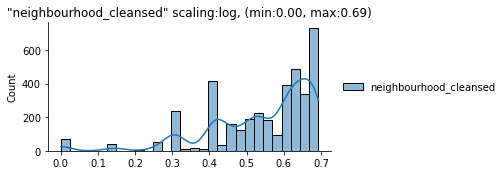

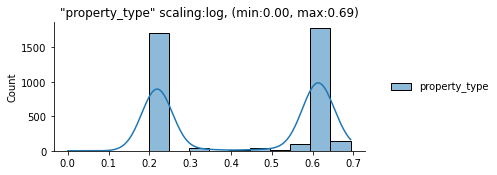

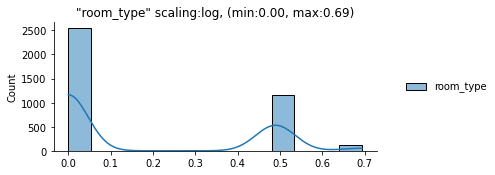

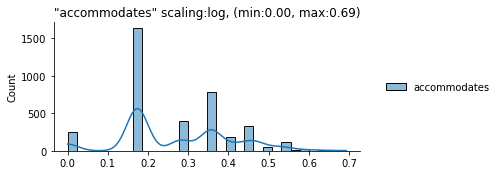

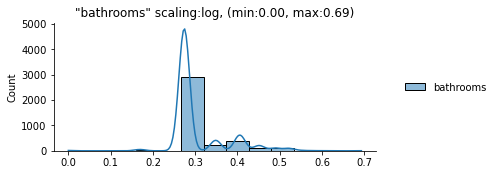

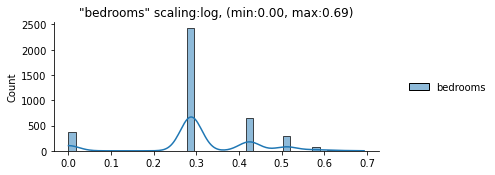

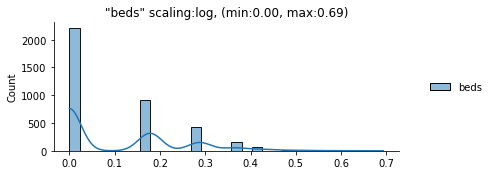

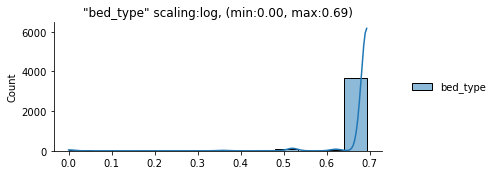

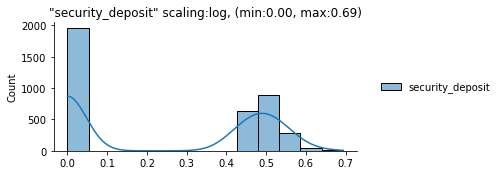

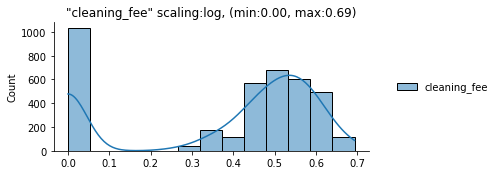

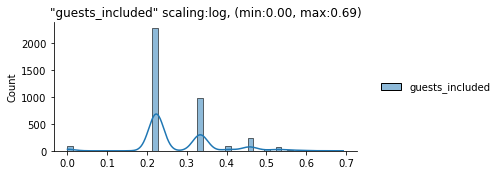

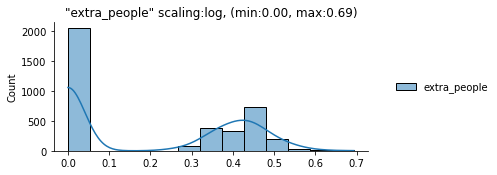

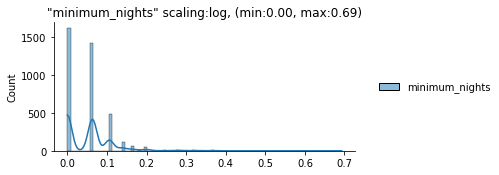

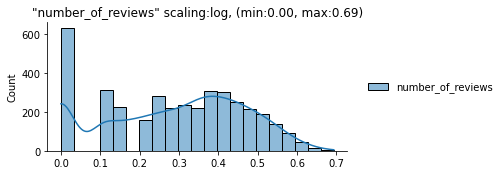

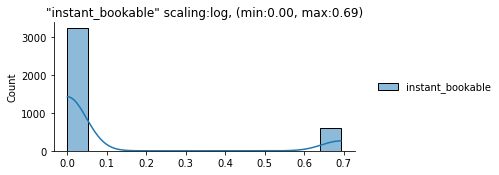

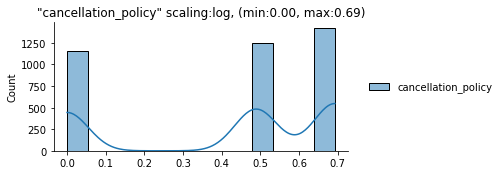

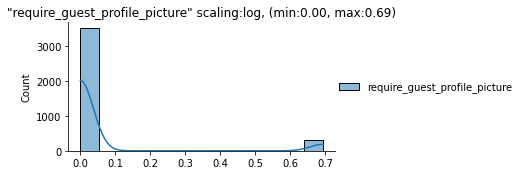

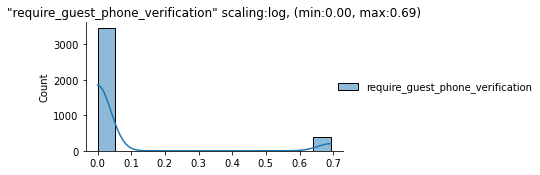

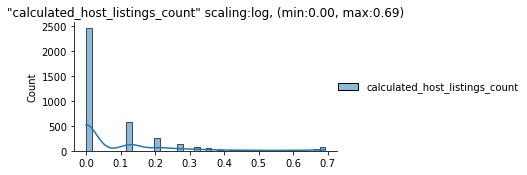

In [35]:
def scaling(f, c, action=None, plot=False):
    tmp = f[[c]].copy()
    if action == 'log':
        tmp = np.log(tmp + 1)
        color = 'r'
    elif action == 'minmax':
        tmp = MinMaxScaler().fit_transform(tmp)
        color = 'g'
    elif action == 'standard':
        tmp = StandardScaler().fit_transform(tmp)
        color = 'b'
    else:
        color = 'k'

    if plot:
        g = sns.displot(tmp, kde=True, color=color)
        g.fig.set_figwidth(7)
        g.fig.set_figheight(2)
        plt.title("\"%s\" scaling:%s, (min:%.2f, max:%.2f)" % (c, action, tmp.min(), tmp.max()))
        plt.show()
    f[c] = tmp

for col in X.columns:
    scaling(X, col, action='log', plot=True)
    scaling(X, col, action='minmax', plot=False)


In [36]:
X

,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,0.990408,0.315741,0.0,0.514158,0.395573,0.415037,0.000000,1.0,0.000000,0.000000,0.481548,0.393913,0.000000,0.899962,0.0,0.705695,0.0,0.0,0.186127
1,0.990408,0.315741,0.0,0.514158,0.395573,0.415037,0.000000,1.0,0.624659,0.723071,0.321928,0.000000,0.091170,0.690628,0.0,1.000000,1.0,1.0,0.511435
2,0.990408,0.884677,0.0,0.877544,0.828521,0.896585,0.736966,1.0,0.856894,1.000000,0.899066,0.651576,0.198391,0.579156,0.0,1.000000,0.0,0.0,0.186127
3,0.990408,0.315741,0.0,0.404784,0.395573,0.000000,0.256996,1.0,0.000000,0.000000,0.321928,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,0.990408,0.884677,0.0,0.664833,0.584963,0.736966,0.415037,1.0,0.823186,0.885507,0.767094,0.571253,0.000000,0.673026,0.0,1.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.758851,0.884677,0.0,0.664833,0.584963,0.736966,0.415037,1.0,0.000000,0.966150,0.321928,0.000000,0.152530,0.153758,0.0,1.000000,0.0,0.0,0.595331
3814,0.944215,0.315741,0.0,0.514158,0.395573,0.415037,0.256996,1.0,0.790665,0.756113,0.584963,0.651576,0.091170,0.236646,0.0,0.705695,0.0,0.0,0.000000
3815,0.946899,0.884677,0.0,0.250311,0.395573,0.415037,0.000000,1.0,0.721352,0.703016,0.481548,0.616792,0.000000,0.000000,0.0,0.705695,0.0,0.0,0.000000
3816,0.873056,0.828245,0.0,0.250311,0.395573,0.000000,0.000000,1.0,0.739894,0.740586,0.321928,0.000000,0.152530,0.000000,0.0,0.705695,0.0,0.0,0.000000


***

Besides neighbourhood_cleansed, number_of_reviews is also highly related to the pricing decision of hosts. Some kinds of extra services, like cleaning_fee, extra_people_fee, and the limitation of minimum_night, are also highly relevant to the pricing of listings. 

And surprisingly, people may don't care about what kind of listings do they live. The pricings of listings are less relevant to what kind of listing are they going to live in.

The Figure is shown below:

***

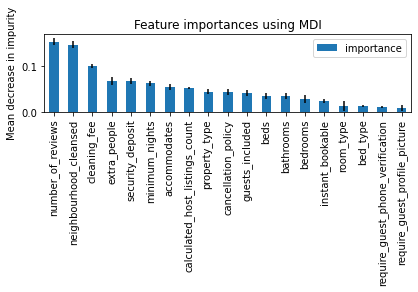

In [37]:
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.DataFrame(importances, index=col_X, columns=['importance'])
forest_importances = forest_importances.sort_values(by='importance', ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Text(0, 0.5, 'price')

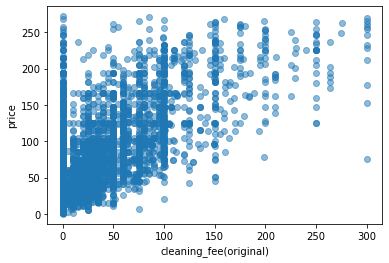

In [38]:
plt.scatter(orig_X['cleaning_fee'].values, y, alpha=0.5)
plt.xlabel('cleaning_fee(original)')
plt.ylabel('price')


### Research Question 3  (What's the trends of occupation rate in difference neighbourhoods?)

In [39]:
# There are 3818 listings in this dataset. 
# Each listing concains 365 daily prices from '2016-01-04' to '2017-01-02'
monthly_occupancy = calendar.df.groupby(['listing_id', 'month', 'available']).count()[['price']].unstack().reset_index().fillna(0)
cols = []
for mc in monthly_occupancy.columns:
    if mc[0] == 'price':
        if mc[1] == 'f':
            col = "occupied"
        else:
            col = "opened"
    else:
        col = mc[0]
    cols.append(col)
monthly_occupancy.columns = cols
# occupancy_rate['occupancy_rate'] = occupancy_rate['occupied'] / (occupancy_rate['occupied'] + occupancy_rate['opened'])
monthly_occupancy.head()


,listing_id,month,occupied,opened
0,3335,1,28.0,2.0
1,3335,2,28.0,1.0
2,3335,3,0.0,31.0
3,3335,4,0.0,30.0
4,3335,5,0.0,31.0


In [40]:
occupancy_rate = pd.merge(monthly_occupancy, 
                          listings.df[['id', 'neighbourhood_cleansed', 'latitude', 'longitude', ]], 
                          left_on='listing_id', right_on='id')
occupancy_rate = occupancy_rate.drop(['id', 'listing_id'], axis=1)
occupancy_rate

,month,occupied,opened,neighbourhood_cleansed,latitude,longitude
0,1,28.0,2.0,Dunlap,47.529846,-122.275840
1,2,28.0,1.0,Dunlap,47.529846,-122.275840
2,3,0.0,31.0,Dunlap,47.529846,-122.275840
3,4,0.0,30.0,Dunlap,47.529846,-122.275840
4,5,0.0,31.0,Dunlap,47.529846,-122.275840
...,...,...,...,...,...,...
45811,8,0.0,31.0,Greenwood,47.700950,-122.353221
45812,9,0.0,30.0,Greenwood,47.700950,-122.353221
45813,10,0.0,31.0,Greenwood,47.700950,-122.353221
45814,11,0.0,30.0,Greenwood,47.700950,-122.353221


In [41]:
occupancy_rate = occupancy_rate.groupby(['neighbourhood_cleansed', 'month'])\
                .sum()[['occupied','opened']].reset_index()
# .unstack().reset_index().fillna(0)
occupancy_rate['available_cnt'] = occupancy_rate['occupied']+occupancy_rate['opened']
occupancy_rate['occupancy_rate'] = occupancy_rate['occupied']/occupancy_rate['available_cnt']
occupancy_rate = occupancy_rate[['neighbourhood_cleansed','month','available_cnt','occupancy_rate']]
occupancy_rate = occupancy_rate.sort_values(by='available_cnt', ascending=False)
occupancy_rate

,neighbourhood_cleansed,month,available_cnt,occupancy_rate
112,Broadway,5,12307.0,0.403266
119,Broadway,12,12307.0,0.274072
117,Broadway,10,12307.0,0.320712
115,Broadway,8,12307.0,0.396035
114,Broadway,7,12307.0,0.409848
...,...,...,...,...
792,Roxhill,1,60.0,0.466667
795,Roxhill,4,60.0,0.000000
802,Roxhill,11,60.0,0.000000
797,Roxhill,6,60.0,0.000000


***

As we can see in the figure shown below, Seattle listings have 2 low seasons: March and December. And there are two high seasos: January and July.

***

Text(0.5, 1.0, 'Occupancy Rate of top 10 neighbourhoods')

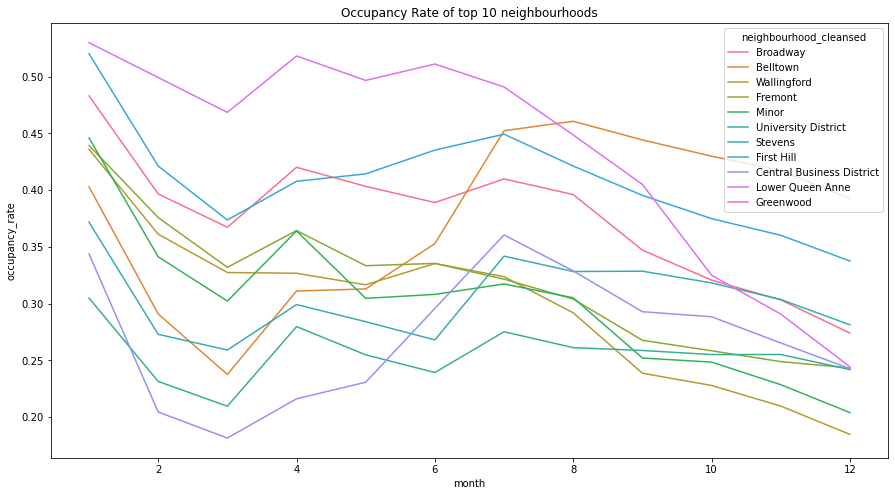

In [44]:
plt.figure(figsize=(15,8))
sns.lineplot(data=occupancy_rate.head(12*10), x="month", y="occupancy_rate", hue="neighbourhood_cleansed")
plt.title('Occupancy Rate of top 10 neighbourhoods')

<a id='conclusions'></a>
## Conclusions

> At the end, summarize your findings and the results that have been performed. 
- The Conclusion should reflect on the steps taken during the data exploration, summarize the main findings in relation to the questions provided at the beginning of the analysis accurately.
- The conclusion points out where additional research can be done or where additional information could be useful and **should have at least 1 limitation explained clearly.**
- The analysis should not state or imply that one change causes another based solely on a correlation. You can refer to this video on [Correlation does not mean Causation](https://youtu.be/VMUQSMFGBDo)


***

###### Conclusions

Seattle listings have 2 low seasons: March and December, and 2 high seasons: January and July.

The ability of earning money in particular districts depend on the scale of listings in that area more than the pricing.

People prefer listings with a great experience and a reasonable price, if reviews are answered within a short time, it will shows that the host is active and willing to make a deal with the customer. This is one of the most important factors to make a deal with customers. And surprisingly, people may don't care about what kind of listings do they live. The pricings of listings are less relevant to what kind of listing are they going to live in.

###### More questions
There are a lot more questions that this dataset could answer me. For example, what the attitudes are there from those comments. What requirements are there from the comments.

The answer to these questions will helps me a lot to understand why some of the listings are far more interested by customers.

***